In [1]:
import pandas as pd 

import matplotlib.pyplot as plt
# we use xgboost gradient boosting decsion trees model for this experiment 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import xgboost as xgb
import scikitplot as skplt


import sys
sys.path.append('../../data/')
import cleaner as dc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('data/moral_appeal_dataset.csv')
df

,ad,moral_appeal
0,psd jobs spring launch webinar monday pmpm vir...,0
1,the aflcio has always fought alongside workers...,1
2,your national monuments are on the chopping block,0
3,join us for a focus group to share your though...,0
4,with president trump nominating a judge with a...,1
...,...,...
19729,we plan to share a video of our first manufact...,1
19730,chendra is suffering and needs to be sent to a...,1
19731,do not even think about it you better grab one gt,1
19732,not long to wait,1


In [3]:
# Lower case
df['ad']= df['ad'].apply(lambda x: x.lower())

# Removing punctuations
df['ad']= df['ad'].str.replace('[^\w\s]','', regex=True)

# Removing numbers
df['ad']= df['ad'].str.replace('\d+','',regex=True)

# Removing extra space 
df['ad']= df['ad'].str.replace('\s+', ' ',  regex=True)

#Apply denoise function
df['ad']= df['ad'].apply(dc.denoise_text)

#Remove stopwords 
df['ad']= df['ad'].apply(dc.remove_stopwords)

#Remove special characters
df['ad']= df['ad'].apply(dc.remove_special_characters)

#Simple stemming 
df['ad']= df['ad'].apply(dc.simple_stemmer)

In [4]:
# vectorize testing and training data 
X_train, X_test, y_train, y_test= train_test_split(df['ad'], df['moral_appeal'] , test_size = 0.2, random_state = 0)

In [5]:
tf_vectorizer = TfidfVectorizer()

X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [15]:
xgb_clf = xgb.XGBClassifier(
  objective='binary:logistic',
  max_depth = 10, 
  subsample = 0.5,
  learning_rate = 0.3,
  gamma = 10,
)
xgb_clf.fit(X_train_tf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=10, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

accuracy:   0.981
                 precision    recall  f1-score   support

no moral appeal       0.97      0.99      0.98      1967
   moral appeal       0.99      0.97      0.98      1980

       accuracy                           0.98      3947
      macro avg       0.98      0.98      0.98      3947
   weighted avg       0.98      0.98      0.98      3947

confusion matrix:
[[1944   23]
 [  53 1927]]



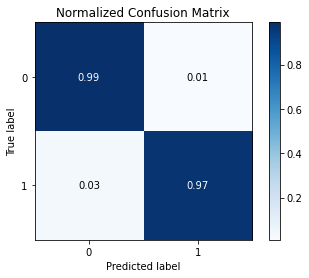

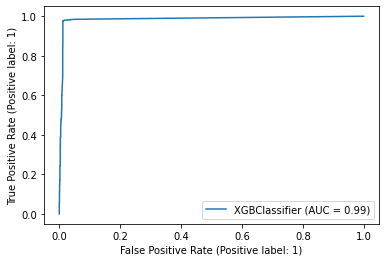

In [17]:
# predict the labels on validation dataset
predictions = xgb_clf.predict(X_test_tf)

# model performance
score = metrics.accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_test, predictions, target_names=['no moral appeal', 'moral appeal']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_test_tf, y_test)

In [12]:
df_val = pd.read_csv('data/sample_moral_appeal.csv')

# Lower case
df_val['ad']= df_val['ad'].apply(lambda x: x.lower())

# Removing punctuations
df_val['ad']= df_val['ad'].str.replace('[^\w\s]','', regex=True)

# Removing numbers
df_val['ad']= df_val['ad'].str.replace('\d+','',regex=True)

# Removing extra space 
df_val['ad']= df_val['ad'].str.replace('\s+', ' ',  regex=True)

#Apply denoise function
df_val['ad']= df_val['ad'].apply(dc.denoise_text)

#Remove stopwords
df_val['ad']= df_val['ad'].apply(dc.remove_stopwords)

#Remove special characters
df_val['ad']= df_val['ad'].apply(dc.remove_special_characters)

#Simple stemming 
df_val['ad']= df_val['ad'].apply(dc.simple_stemmer)

accuracy:   0.711
                 precision    recall  f1-score   support

no moral appeal       0.64      0.70      0.67        54
   moral appeal       0.77      0.72      0.74        74

       accuracy                           0.71       128
      macro avg       0.71      0.71      0.71       128
   weighted avg       0.72      0.71      0.71       128

confusion matrix:
[[38 16]
 [21 53]]



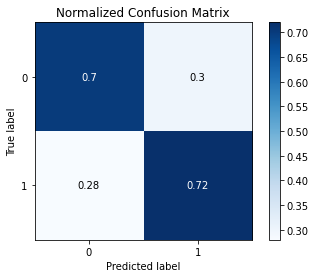

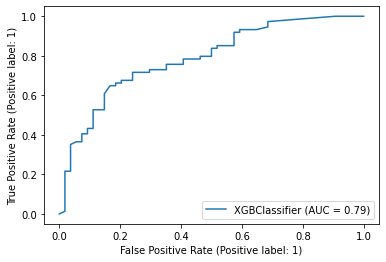

In [18]:
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['moral_appeal']

y_pred = xgb_clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=['no moral appeal', 'moral appeal']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_val, y_val)